# 7 Step grid transformation to align JP'gridded variables with WCVI model domain

1) Unstagger the U and V velocities of JP's model output (interpolate the U and V velocities of JP to the T grid point of JP)

In [72]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import os,sys
import numpy as np
from salishsea_tools import viz_tools, geo_tools,nc_tools
from grid_alignment import calculate_initial_compass_bearing as cibc
from scipy.interpolate import griddata, interp1d
import matplotlib.cm as cm
%matplotlib inline

Load JP's T-points data and unstagger his U and V points onto the T points

In [2]:
fname_T = '/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20160513_00874080_grid_T.nc'

Let's look at the variables inside the grid_T file

In [3]:
nc_tools.show_variables(nc.Dataset(fname_T))
nc_tools.show_dimensions(nc.Dataset(fname_T))

odict_keys(['nav_lon', 'nav_lat', 'deptht', 'time_counter', 'time_counter_bnds', 'votemper', 'vosaline', 'sosstsst', 'sosaline', 'sossheig', 'sowaflup', 'sowaflcd', 'sosalflx', 'sohefldo', 'soshfldo', 'somxl010', 'somixhgt', 'soicecov', 'sohefldp', 'sosafldp', 'sowafldp', 'sobowlin'])
<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 715

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 1021

<class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 50

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 1

<class 'netCDF4._netCDF4.Dimension'>: name = 'bnds', size = 2



Lets locate the lat and lon of the T grid points

In [4]:
with nc.Dataset(fname_T, 'r') as cnc:
    nav_lon_T = cnc.variables['nav_lon'][:]; nav_lat_T = cnc.variables['nav_lat'][:]

    
print(nav_lon_T.shape, nav_lat_T.shape)

(1021, 715) (1021, 715)


Let's see where the lat and lon of the U and V grid data lie from the other 2 output files

In [5]:
fname_U, fname_V = '/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20160513_00874080_grid_U.nc', \
                      '/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20160513_00874080_grid_V.nc'

Let's look at the variables inside the grid_U and grid_V files

In [6]:
nc_tools.show_variables(nc.Dataset(fname_U))
nc_tools.show_dimensions(nc.Dataset(fname_U))

odict_keys(['nav_lon', 'nav_lat', 'depthu', 'time_counter', 'time_counter_bnds', 'vozocrtx', 'sozotaux'])
<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 715

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 1021

<class 'netCDF4._netCDF4.Dimension'>: name = 'depthu', size = 50

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 1

<class 'netCDF4._netCDF4.Dimension'>: name = 'bnds', size = 2



In [7]:
nc_tools.show_variables(nc.Dataset(fname_V))
nc_tools.show_dimensions(nc.Dataset(fname_V))

odict_keys(['nav_lon', 'nav_lat', 'depthv', 'time_counter', 'time_counter_bnds', 'vomecrty', 'sometauy'])
<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 715

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 1021

<class 'netCDF4._netCDF4.Dimension'>: name = 'depthv', size = 50

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 1

<class 'netCDF4._netCDF4.Dimension'>: name = 'bnds', size = 2



In [8]:
with nc.Dataset(fname_U, 'r') as cnu:
    nav_lon_U = cnu.variables['nav_lon'][:]; nav_lat_U = cnu.variables['nav_lat'][:]
    
    
print(nav_lon_U.shape, nav_lat_U.shape)

(1021, 715) (1021, 715)


In [9]:
u_vel = nc.Dataset(fname_U)
v_vel = nc.Dataset(fname_V)

In [10]:
ugrid = u_vel.variables['vozocrtx']
vgrid = v_vel.variables['vomecrty']
zlevels = u_vel.variables['depthu']
timesteps = u_vel.variables['time_counter']

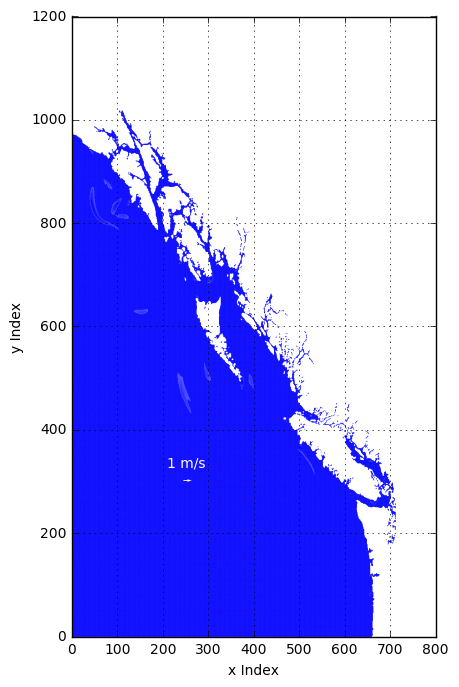

In [11]:
# Define the slice to plot
t, zlevel = 0, 0
# Slice and mask the arrays
ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel,...], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, ...], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)

# Plot the velocity vectors
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
quiver = ax.quiver(u_tzyx, v_tzyx, color='blue', pivot='mid')
ax.grid()
# Axes label and title
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.quiverkey(quiver, 252, 302, 4, '1 m/s', coordinates='data', color='white', labelcolor='white')

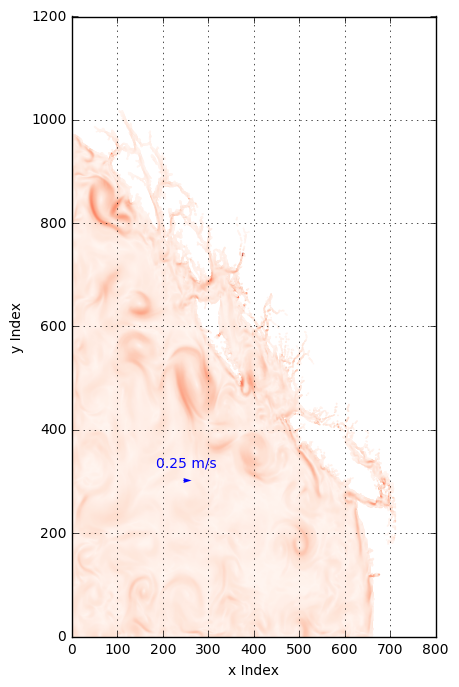

In [12]:
# Define the slice to plot
t, zlevel = 0, 0
# Slice and mask the arrays
ugrid_tzyx = np.ma.masked_values(ugrid[t, zlevel,...], 0)
vgrid_tzyx = np.ma.masked_values(vgrid[t, zlevel, ...], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))

# Plot the velocity vectors
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
quiver = ax.quiver(u_tzyx, v_tzyx, speeds, pivot='mid', cmap='Reds', width=0.005)
ax.grid()
# Axes label and title
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.quiverkey(quiver, 252, 302, 4, '0.25 m/s', coordinates='data', color='blue', labelcolor='blue')

2) To calculate the angle of JP's grid from a rectangular domain in CCW sense

In [13]:
fname_coord = "/data/mdunphy/NEP036-N30-OUT/INV/coordinates.nc"

lat_bnds, lon_bnds = [45, 53], [-135, -123]




with nc.Dataset(fname_coord, 'r') as cnc:
    glamt = cnc.variables['glamt'][:]; gphit = cnc.variables['gphit'][:]
    glamu = cnc.variables['glamu'][:]; gphiu = cnc.variables['gphiu'][:]
    glamv = cnc.variables['glamv'][:]; gphiv = cnc.variables['gphiv'][:]
    
   
## slice out portion of JP's domain which interests us    
#lon_inds = np.where((glamt > lon_bnds[0]) & (glamt < lon_bnds[1]))
#lat_inds = np.where((gphit > lat_bnds[0]) & (gphit < lat_bnds[1]))

#glamt_sliced = glamt[lon_inds[0],lon_inds[1]]


# First point
lonA = glamu[0:-2,0:-2]
latA = gphiu[0:-2,0:-2]
# Second point
lonB = glamu[0:-2,1:-1]
latB = gphiu[0:-2,1:-1]



In [20]:
bearing = np.zeros(lonA.shape)
for j in range(lonA.shape[0]):
    for i in range(lonA.shape[1]):
        bearing[j,i] = cibc((lonA[j,i],latA[j,i]),(lonB[j,i],latB[j,i]))

In [21]:
bearing1 = cibc((lonA,latA),(lonB,latB))  # no loop neeeded


In [22]:
np.max(np.abs(bearing-bearing1))

0.0

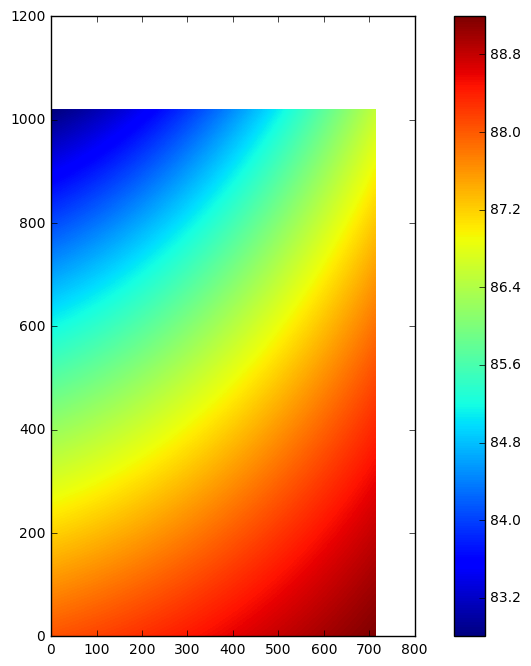

In [23]:
bearing_actual = 90 - bearing



fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(bearing_actual)
fig.colorbar(mesh)

In [71]:
U_unstgg_at_T = griddata((glamu,gphiu), u_tzyx, (glamt,gphit), method='nearest')

ValueError: different number of values and points

In [33]:
u_tzyx.shape

(1020, 714)

3) We rotate the U and V velocities of JP to E-N direction 


 When we unstagger u and v (u_tzyx, v_tzyx) have one grid point less than their previous counterparts (u_grid and v_grid)

 We need to calculate the magnitude and taninv(V/U) 

In [82]:


mag_vel = np.sqrt(np.multiply(u_tzyx,u_tzyx), np.multiply(v_tzyx,v_tzyx))


ang_vel = np.degrees(np.arctan2(v_tzyx, u_tzyx))


print(ang_vel.shape)

print(mag_vel.shape)

print(bearing_actual.shape)


#Let us make the bearing and angle of same shape so that we can add the angle to the bearing

Ny,Nx = ang_vel.shape

J = slice(0, Ny-1)
I = slice(0, Nx-1)

ang_vel = ang_vel[J,I]
mag_vel = mag_vel[J,I]


print(ang_vel.shape)
print(mag_vel.shape)

(1020, 714)
(1020, 714)
(1019, 713)
(1019, 713)
(1019, 713)


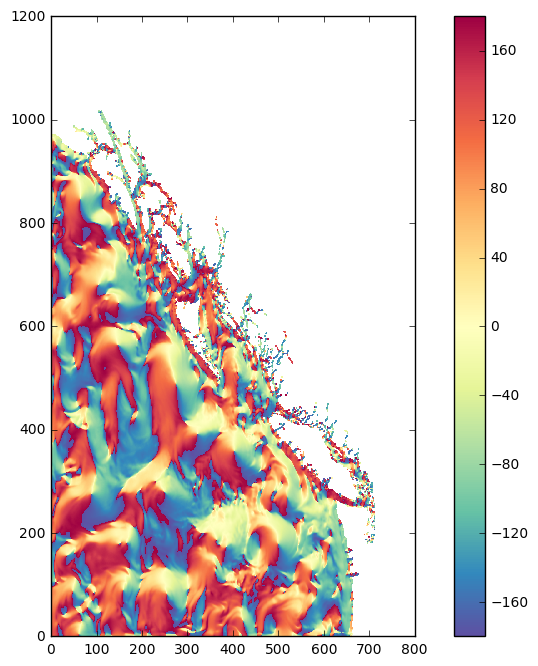

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(ang_vel, cmap =cm.Spectral_r)
fig.colorbar(mesh)

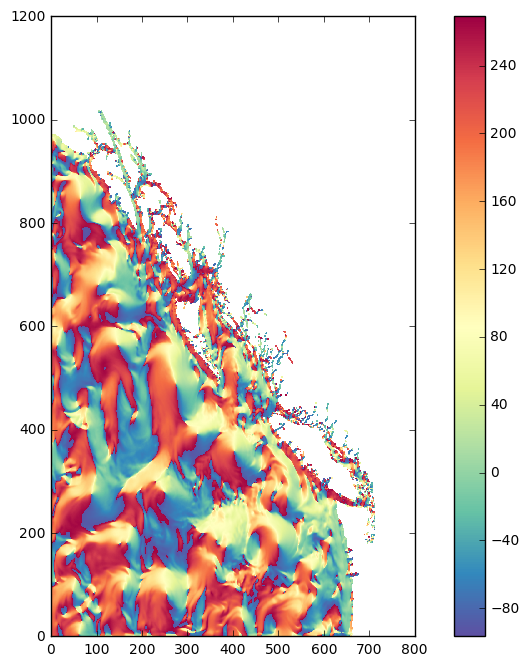

In [84]:
angle_unrotated = ang_vel + bearing_actual;

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(angle_unrotated, cmap =cm.Spectral_r)
fig.colorbar(mesh)

In [97]:
u_unrotated = mag_vel*np.cos(np.radians(angle_unrotated))

v_unrotated = mag_vel*np.sin(np.radians(angle_unrotated))



(102, 72)

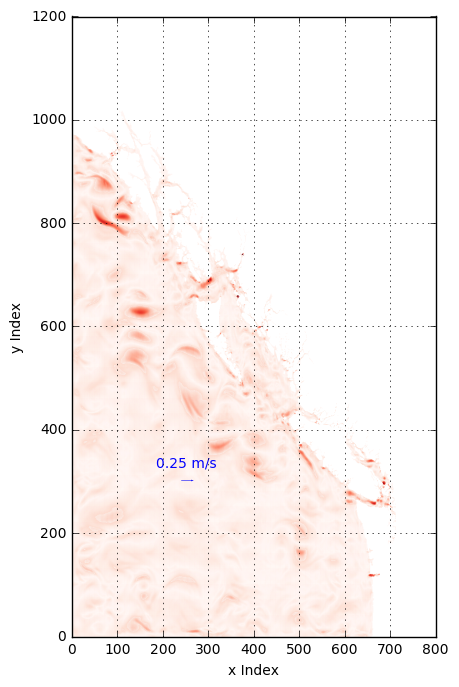

In [115]:

# mask the arrays
u_unrotated_masked = np.ma.masked_values(u_unrotated[...], 0)
v_unrotated_masked = np.ma.masked_values(v_unrotated[...], 0)

speeds = np.sqrt(np.square(u_unrotated_masked) + np.square(v_unrotated_masked))

# Plot the velocity vectors
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)


arrowsteps = 1
x_slice = u_unrotated_masked[::arrowsteps,::arrowsteps]
y_slice = v_unrotated_masked[::arrowsteps,::arrowsteps]
speed_slice = speeds[::arrowsteps, ::arrowsteps]
quiver = ax.quiver(x_slice, y_slice, speed_slice, pivot='mid', cmap='Reds', width=0.0015)
ax.grid()
# Axes label and title
ax.set_xlabel('x Index')
ax.set_ylabel('y Index')
ax.quiverkey(quiver, 252, 302, 4, '0.25 m/s', coordinates='data', color='blue', labelcolor='blue')

In [35]:
print(bearing.shape)

print(ang_vel.shape)






(1019, 713)
(1020, 714)


In [ ]:
np.where((bearing == np.min(bearing)))


In [ ]:
bearing[1020,0]

In [ ]:
bearing[0,714]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(bearing -np.mean(bearing))
fig.colorbar(mesh)



In [ ]:
np.max(bearing - np.mean(bearing)), np.min(bearing - np.mean(bearing))

In [ ]:
np.where((bearing - np.mean(bearing) == np.max(bearing - np.mean(bearing))))

In [ ]:
np.where((bearing - np.mean(bearing) == np.min(bearing - np.mean(bearing))))

In [ ]:
print(np.min(nav_lon_T), np.max(nav_lon_T))


print(np.min(nav_lat_T), np.max(nav_lat_T))

In [ ]:
print(np.min(x), np.max(x))

print(np.min(y), np.max(y))

In [ ]:
np.max(x)

In [ ]:

cibc(tuple(nav_lon_T,nav_lat_T),tuple(nav_lat_T,nav_lon_T)).shape

In [ ]:
Nx

In [ ]:
Ny

In [ ]:
x.shape

In [ ]:
a.shape


In [ ]:
lon[:]

In [ ]:
angle

In [ ]:
print(bearing.shape)

In [ ]:
Nx

In [ ]:
bearing.shape

In [ ]:

i

In [ ]:
bearing.shape

In [ ]:
bearing[1020,0]

In [ ]:
bearing[0,714]